In [6]:
import tensorflow as tf
from keras.models import Sequential 
from sklearn import datasets
from keras.layers import Dense, Activation
import numpy as np

In [7]:
import cifar10
cifar10.data_path = "data/CIFAR-10/"
cifar10.maybe_download_and_extract()
class_names = cifar10.load_class_names()
x_train, cls, y_train = cifar10.load_training_data()
x_test, clas, y_test = cifar10.load_test_data()
class_names

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

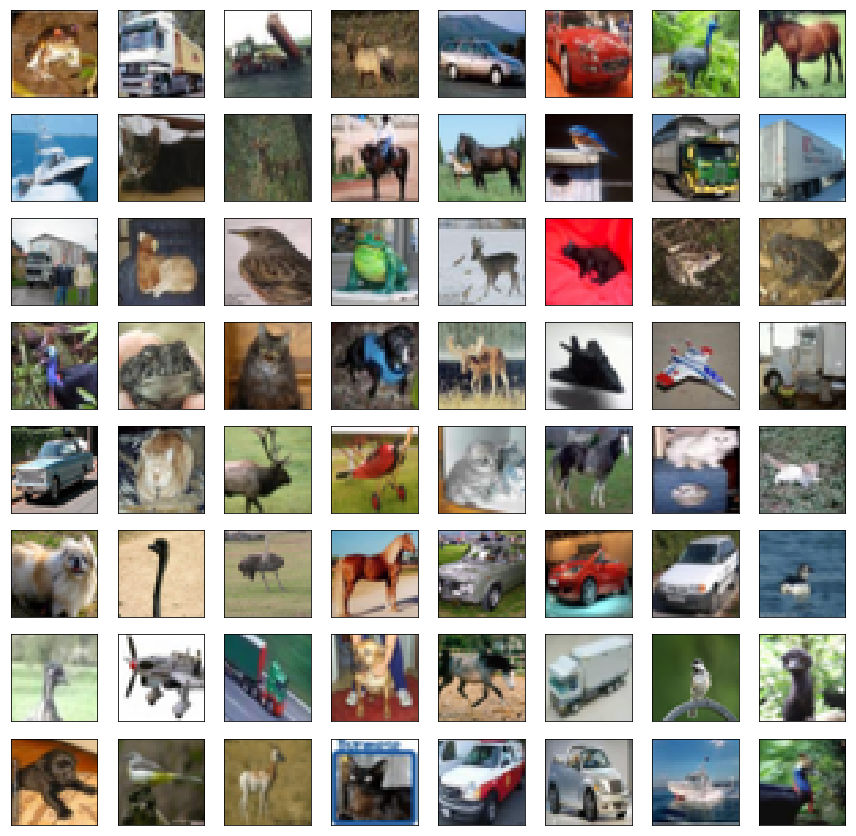

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,15))
for i in range(64):
    ax = fig.add_subplot(8,8, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap = plt.cm.bone)
plt.show()

In [9]:
#using tensorflow to solve this dataset 

In [10]:
input_width = 32
input_height = 32
input_channels = 3
n_input = 3072
n_conv1 = 40
n_conv2 = 64
conv1_k = 5
conv2_k = 5
n_hidden = 1024
n_out = 10
pooling_window_size = 2

In [11]:
weights = {
    "wc1" : tf.Variable(tf.random_normal([conv1_k, conv1_k, input_channels, n_conv1])),
    "wc2" : tf.Variable(tf.random_normal([conv2_k, conv2_k, n_conv1, n_conv2])),
    "wh1" : tf.Variable(tf.random_normal([input_width//4* input_height//4* n_conv2, n_hidden])),
    "wout": tf.Variable(tf.random_normal([n_hidden, n_out]))
}


biases = {
    "bc1" : tf.Variable(tf.random_normal([n_conv1])),
    "bc2" : tf.Variable(tf.random_normal([n_conv2])),
    "bh1" : tf.Variable(tf.random_normal([n_hidden])),
    "bout": tf.Variable(tf.random_normal([n_out]))    
}

In [12]:
def conv(x, weights, bias, strides = 1):
    out = tf.nn.conv2d(x, weights, padding="SAME", strides=[1, strides, strides, 1])
    out = tf.nn.bias_add(out, bias)
    return tf.nn.relu(out)

def maxpooling(x, k = 2):
    return tf.nn.max_pool(x, padding="SAME", ksize=[1, k, k, 1], strides=[1, k, k, 1])

In [13]:
def cnn(x, weights, biases):
    #x = tf.reshape(x, shape = [-1,input_height, input_width, 3])
    conv1 = conv(x, weights["wc1"], biases["bc1"])
    conv1 = maxpooling(conv1, k = pooling_window_size)
    
    conv2 = conv(conv1, weights["wc2"], biases["bc2"])
    conv2 = maxpooling(conv2, k = pooling_window_size)
    
    hidden_input = tf.reshape(conv2, shape=[-1, input_width//4 * input_height//4 * n_conv2])
    hidden_output = tf.add(tf.matmul(hidden_input, weights["wh1"]), biases['bh1'])
    hidden_output = tf.nn.relu(hidden_output)
    
    out =  tf.add(tf.matmul(hidden_output, weights["wout"]), biases['bout'])
    return out


In [14]:
x = tf.placeholder("float", [None, input_height, input_width, input_channels])
y = tf.placeholder("float", [None, n_out])
pred = cnn(x, weights, biases)

In [29]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimize = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [30]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [31]:
batch_size = 100
num_batches = int(len(x_train)/batch_size)
for i in range(8):
    total_cost = 0
    for j in range(num_batches):
        batch_x = x_train[j*batch_size:(j*batch_size)+batch_size]
        batch_y = y_train[(j*batch_size):((j*batch_size)+batch_size)]
        _ , c = sess.run([optimize, cost], feed_dict={x:batch_x, y:batch_y})
        total_cost +=c
    print(total_cost)


8142656.049316406
3437110.018310547
2247371.9409179688
1578294.6405029297
1170982.1687011719
892647.7102050781
690151.2719116211
546729.7702026367


In [32]:
predictions = tf.argmax(pred, 1)
correct_labels = tf.argmax(y, 1)
correct_predictions = tf.equal(predictions, correct_labels)
predictions,correct_predictions  = sess.run([predictions, correct_predictions], feed_dict={x:x_test,
                                              y:y_test})


In [33]:
p = (correct_predictions == False).sum()
p
accuracy = 1 - p/len(correct_predictions)
print(accuracy)

0.4202
